libraries


In [94]:
# %%
import os, sys, glob
from nilearn import image
from nilearn import plotting
import numpy as np
import pandas as pd

from scipy import io
import matplotlib.pyplot as plt
import matplotlib.cm
cmap = matplotlib.cm.get_cmap('Reds')

%matplotlib inline

sys.path.append('/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages')
import rsatoolbox
import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
from rsatoolbox.model import ModelFixed
from rsatoolbox.inference import eval_fixed

# function load data

In [70]:
def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))


def load_outcome(data_dir, sub, ses):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_outcome = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist:
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_04outcome = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns = ['trial_order', 'run_order'],
                            values=['event04_actual_angle']) #, aggfunc='first')
        seswise_04outcome.columns  = [ col[0]+'_'+str(col[1]) for col in seswise_04outcome.columns.values]
        seswise_04outcome = seswise_04outcome.reset_index()
        seswise_04outcome["condition"] = task + '_' + seswise_04outcome['param_cue_type'].astype(str) + '_' + seswise_04outcome["param_stimulus_type"]

        # reorder values
        seswise_04outcome['stim_order'] = seswise_04outcome['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        seswise_04outcome['cue_order'] = seswise_04outcome['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        ses_outcome = seswise_04outcome.sort_values(['cue_order','stim_order'])
        seswise_outcome = pd.concat([seswise_outcome, ses_outcome])
    return(seswise_outcome.reset_index(drop = True))


def load_fmri(singletrial_dir, sub, ses, run, atlas):
    from nilearn import datasets
    from nilearn.maskers import NiftiLabelsMasker
    dataset = datasets.fetch_atlas_schaefer_2018()
    atlas_filename = dataset.maps
    # labels = dataset.labels
    labels = np.insert(dataset.labels, 0, 'Background')
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                            memory='nilearn_cache', verbose=5)
    if atlas == True: 
        arr = np.empty((0, len(dataset['labels'])), int)  
    elif atlas == False:
        get_shape = glob.glob(os.path.join(
                singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
        get_shape_data = image.mean_img(image.concat_imgs(get_shape)).get_fdata().ravel()
        arr = np.empty((0, get_shape_data.shape[0]), int)
    # task_array = np.empty((18,0), int)
    
    for runtype in ['pain','cognitive', 'vicarious']:
        stim_H_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]

        
        # task_array = np.vstack((task_array, runwise_array))
        # arr = np.append(arr, runwise_array, axis=0)
        if atlas == True:
            stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H))
            stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H))
            stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H))
            stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L))
            stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L))
            stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L))
            runwise_array = masker.fit_transform(image.concat_imgs([stim_H_cue_H_mean,
                                                          stim_M_cue_H_mean,
                                                          stim_L_cue_H_mean,
                                                          stim_H_cue_L_mean,
                                                          stim_M_cue_L_mean,
                                                          stim_L_cue_L_mean
                                                           ])) # (trials, parcels)
            arr = np.concatenate((arr,runwise_array),axis=0)
    # np.vstack((arr, runwise_array))
        elif atlas == False:
            stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
            stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
            stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
            stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
            stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
            stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()
            runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
            arr = np.concatenate((arr,runwise_array),axis=0)
        mask = ~np.isnan(image.load_img(image.concat_imgs(stim_H_cue_H)).get_fdata())
    return(mask, arr, stim_flist)

def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [43]:
# load brain data
sub_list = ['sub-0061']
ses_list = ['ses-01', 'ses-03']#, 'ses-04']
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        des = {'session': ses, 'subj': sub}
        # load behavioral data expectation rating
        expect_df = pd.DataFrame()
        expect_df = load_expect(data_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                sub = sub, ses = ses)
        obs_des = {'pattern': np.array(expect_df.condition)}
        chn_des = {'ratings': np.array(['ratings_' + str(x) for x in np.arange(4)])}
        beh_expect.append(rsd.Dataset(measurements=np.array(expect_df.filter(regex='event02_')),
                                descriptors=des,
                                obs_descriptors=obs_des,
                                channel_descriptors=chn_des))
        # load behavioral data outcome rating
        outcome_df = load_outcome(data_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                sub = sub, ses = ses)
        beh_outcome.append(rsd.Dataset(measurements=np.array(outcome_df.filter(regex='event04_')),
                        descriptors=des,
                        obs_descriptors=obs_des,
                        channel_descriptors=chn_des))
        # load fMRI data
        mask, fmri_df, stim_flist = load_fmri(singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/',
                      sub = sub, ses = ses, run = '*', atlas = True)
        obs_des = {'pattern': np.array(expect_df.condition)}
        fmri_data.append(rsd.Dataset(measurements=fmri_df,
                                descriptors=des,
                                obs_descriptors=obs_des,
                                channel_descriptors={'roi': np.array(['roi_' + str(x) for x in np.arange(fmri_df.shape[1])])}))
# get mask
# get searchlight_RDM

[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]0.4s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]47.6s, 0.8min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]98.0s, 1.6min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii

## build RDM

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/data/noise.py:149: RuntimeWarning: invalid value encountered in double_scalars
  s_shrink = b2 / d2 * m * np.eye(s.shape[0]) \
/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/data/noise.py:150: RuntimeWarning: invalid value encountered in double_scalars
  + (d2-b2) / d2 * s


(<Figure size 400x200 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fe304591700>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fe3042cb0d0>}}))

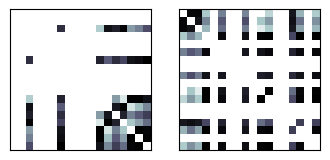

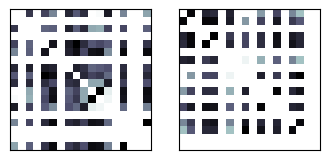

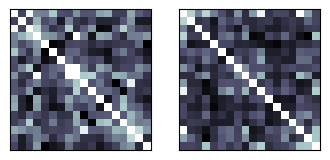

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


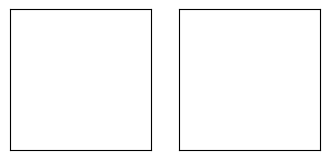

In [55]:
rdms_expect = rsr.calc_rdm(beh_expect)
rdms_outcome = rsr.calc_rdm(beh_outcome)
rdms_fmri = rsr.calc_rdm(fmri_data)
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(fmri_data, obs_desc='pattern', method='shrinkage_eye')
rdm_fmri_maha_shrink = rsatoolbox.rdm.calc_rdm(fmri_data, descriptor='pattern', method='mahalanobis', noise=noise_prec_shrink)

rsatoolbox.vis.show_rdm(rdms_expect)
rsatoolbox.vis.show_rdm(rdms_outcome)
rsatoolbox.vis.show_rdm(rdms_fmri)
rsatoolbox.vis.show_rdm(rdm_fmri_maha_shrink)

In [58]:
lab = np.load('/Users/h/Downloads/118_animate_labels.npy')
lab_rdm = np.load('/Users/h/Downloads/118_animate_RDM.npy')
lab_rdm

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [88]:
lab_rdm.shape

(118, 118)

## build categorical RDM

(<Figure size 200x200 with 1 Axes>,
 array([[<AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fe2e1efd6d0>}}))

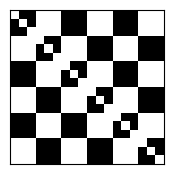

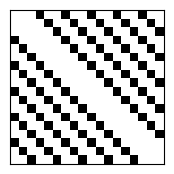

In [199]:
cue_vector = [1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0]
cue_list = ['high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue',
                       'high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue',
                       'high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue'
                        ]
cue_rdm = rsatoolbox.rdm.rdms.get_categorical_rdm(cue_vector, category_name='cue')
rsatoolbox.vis.show_rdm(cue_rdm)

stim_vector = [1,0,-1,1,0,-1,1,0,-1,1,0,-1,1,0,-1,1,0,-1]
stim_vector = [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]
stim_rdm = rsatoolbox.rdm.rdms.get_categorical_rdm(stim_vector, category_name='stimulus_intensity')
rsatoolbox.vis.show_rdm(stim_rdm)

# model

In [152]:
model_cue = rsatoolbox.model.ModelFixed('test', cue_rdm)
pred = model.predict() # returns a numpy vectorized format
pred_rdm = model.predict_rdm() # returns a RDMs object

In [164]:

rsatoolbox.rdm.compare(rdms_fmri[0], #rdms_fmri.get_matrices()), 
                       cue_rdm, #rdms_expect.get_matrices()), 
                    #    dissimilarity_measure = 'Euclidean',
                       method='cosine', sigma_k=None)

array([[0.70901498]])

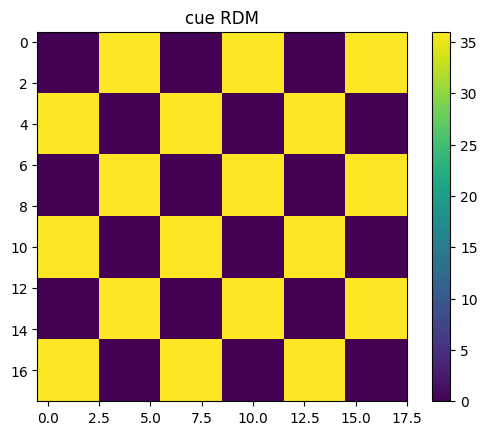

In [93]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
# %% Categorical RDM
cue_category = np.array([[1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1],
                [-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1]])
rdm_cue = pairwise_distances(cue_category, metric='manhattan')

plt.imshow(rdm_cue)
plt.colorbar()
plt.title("cue RDM")
plt.show()

# rdm_cue = rsd.Dataset(measurements=cue_category,
#                                 descriptors=des,
#                                 obs_descriptors=obs_des,
#                                 channel_descriptors={'pattern': np.array(['pattern_' + str(x) for x in np.arange(cue_category.shape[1])])})
# rdms_cue = rsr.calc_rdm(rdm_cue)
cue_model = ModelFixed('cue RDM', upper_tri(cue_category))


In [159]:
cue_rdm

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
  1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
  0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.
  1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
  1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
  1. 1. 1. 1. 1. 1. 0. 0. 0.]]
descriptors = 
{}
rdm_descriptors = 
{'index': [0]}
pattern_descriptors = 
{'cue': array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]), 'index': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])}

In [161]:
import rsatoolbox
# generate 2 random model RDMs of 10 conditions
# model_features = [rsatoolbox.data.Dataset(np.random.rand(10, 7)) for i in range(2)]
# model_rdms_cue = rsatoolbox.rdm.calc_rdm(cue_rdm)
model_cue = rsatoolbox.model.ModelWeighted('test', cue_model)

AttributeError: 'ModelFixed' object has no attribute 'ndim'

In [162]:
cue_model

In [95]:
eval_results = evaluate_models_searchlight(rdms_fmri, cue_model, eval_fixed, method='spearman', n_jobs=3)


Evaluating models for each searchlight: 100%|██████████| 2/2 [00:00<00:00, 64.57it/s]


In [97]:
eval_results
eval_score = [np.float(e.evaluations) for e in eval_results]

/var/folders/w8/z3vy42z17hq5gc9r_5hzsgxw0000gn/T/ipykernel_82444/218187102.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eval_score = [np.float(e.evaluations) for e in eval_results]


In [98]:
eval_score

[-0.0696734912862928, -0.13430677256464102]

In [ ]:
https://rsatoolbox.readthedocs.io/en/stable/demo_searchlight.html

In [ ]:
cue_list  = np.array(['high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue',
                       'high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue',
                       'high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue'
                        ])
cue_array = np.array([1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0])
cue_rdm_model = rsatoolbox.rdm.calc_rdm(cue_array, descriptor={'cuelist': cue_list}, 
                                        #obs_des = {'pattern': np.array(expect_df.condition)},
                                        method='mahalanobis')


TypeError: calc_rdm() got an unexpected keyword argument 'obs_des'

In [63]:
cue_list  = np.array(['high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue',
                       'high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue',
                       'high_cue', 'high_cue', 'high_cue', 'low_cue','low_cue','low_cue'
                        ])
cue_array = np.array([1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0])
cue_rdm_model = rsatoolbox.rdm.calc_rdm(cue_array, descriptor={'cuelist': cue_list}, 
                                        #obs_des = {'pattern': np.array(expect_df.condition)},
                                        method='mahalanobis')


TypeError: calc_rdm() got an unexpected keyword argument 'obs_des'

# searchlight


In [ ]:

# from nilearn import datasets

# atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)

# from rsatoolbox.searchlight import Searchlight

# searchlight = Searchlight(atlas=atlas.maps, seed=0)
# from rsatoolbox.searchlight import Searchlight

# searchlight = Searchlight(atlas=atlas.maps, seed=0)

# compare

In [149]:

rsatoolbox.rdm.compare(rsatoolbox.rdm.RDMs(rdms_fmri.dissimilarities), #rdms_fmri.get_matrices()), 
                       rsatoolbox.rdm.RDMs(rdms_expect.dissimilarities), #rdms_expect.get_matrices()), 
                    #    dissimilarity_measure = 'Euclidean',
                       method='cosine', sigma_k=None)

ValueError: cannot reshape array of size 91 into shape (2,newaxis)

In [123]:
from rsatoolbox.rdm import compare_cosine
cosine_fmri_cue = compare_cosine(rdms_fmri, rdms_expect)

ValueError: cannot reshape array of size 91 into shape (2,newaxis)

In [103]:
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight

# get searchlight center and neighbor
centers, neighbors = get_volume_searchlight(mask[:, :, :,0], radius=12, threshold=0.5)
SL_RDM = get_searchlight_RDMs(fmri_data[0].measurements, centers, neighbors, fmri_data[0].measurements.shape[0], method='correlation')
eval_results = evaluate_models_searchlight(SL_RDM, cue_model, eval_fixed, method='spearman', n_jobs=3)


Finding searchlights...:   2%|▏         | 8281/458294 [00:10<09:22, 799.97it/s] 


KeyboardInterrupt: 

In [50]:
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight

# get searchlight center and neighbor
centers, neighbors = get_volume_searchlight(mask[:, :, :,0], radius=12, threshold=0.5)
SL_RDM = get_searchlight_RDMs(fmri_data[0].measurements, centers, neighbors, fmri_data[0].measurements.shape[0], method='correlation')

Finding searchlights...:   1%|          | 3305/458294 [00:05<12:06, 626.02it/s]


KeyboardInterrupt: 

# chat gpt

(<Figure size 200x200 with 1 Axes>,
 array([[<AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7fe303484400>}}))

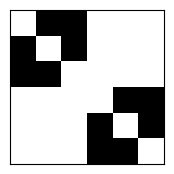

In [138]:
from rsatoolbox.rdm import rescale

# Define your levels
levels = ['high cue', 'high cue', 'high cue', 'low cue', 'low cue', 'low cue']

# Convert levels to integers
level_ints = [1 if level == 'high cue' else 0 for level in levels]

# Create a square matrix of pairwise differences
n_items = len(levels)
rdm = np.zeros((n_items, n_items))
for i in range(n_items):
    for j in range(i, n_items):
        rdm[i, j] = abs(level_ints[i] - level_ints[j])
        rdm[j, i] = rdm[i, j]

# Rescale the RDM to a categorical RDM
cat_rdm = rescale(rdm, rdm_descriptor={'name': 'category', 'levels': ['high cue', 'low cue']})

ImportError: cannot import name 'rescale' from 'rsatoolbox.rdm' (/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/rdm/__init__.py)

In [190]:
b, l = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))
b = b.flatten()
l = l.flatten()

In [270]:
import numpy as np

# Generate the meshgrid
b, l = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))

# Define the rotation matrices
c1 = np.array([[np.cos(np.deg2rad(45)), np.sin(np.deg2rad(45))],
              [-np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])
c2 = np.array([[np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45))],
              [np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])

# Reshape l and b into 2D arrays
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)

# Create xy
xy = np.concatenate([np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c1), c1.T), 
                      np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c2), c2.T)], axis=0)


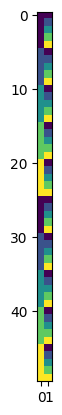

In [271]:
plt.imshow(xy)

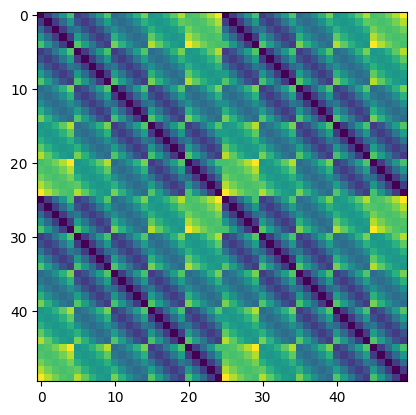

In [272]:
from scipy.spatial.distance import pdist, squareform

rdm = squareform(pdist(xy))
plt.imshow(rdm)


# Apply to spacetop

In [312]:
np.dot(xy, c1)

array([[-7.85046229e-17, -1.41421356e+00],
       [-7.07106781e-01, -7.07106781e-01],
       [-1.41421356e+00,  1.43539982e-16],
       [ 7.07106781e-01, -7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [-7.07106781e-01,  7.07106781e-01],
       [-7.85046229e-17, -1.41421356e+00],
       [-7.07106781e-01, -7.07106781e-01],
       [-1.41421356e+00,  1.43539982e-16],
       [ 7.07106781e-01, -7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [-7.07106781e-01,  7.07106781e-01]])

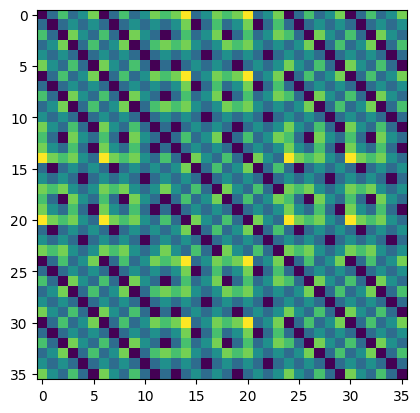

In [342]:
import numpy as np

# Generate the meshgrid
b, l = np.meshgrid(np.arange(-1, 2), np.arange(-1,1 ))

# Define the rotation matrices
c1 = np.array([[np.cos(np.deg2rad(45)), np.sin(np.deg2rad(45))],
              [-np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])

c2 = np.array([[np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45))],
              [np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])

c3 = np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))],
              [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])

c4 = np.array([[np.cos(np.deg2rad(90)), -np.sin(np.deg2rad(90))],
              [np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

c5 = np.array([[np.cos(np.deg2rad(135)), -np.sin(np.deg2rad(135))],
              [np.sin(np.deg2rad(135)), np.cos(np.deg2rad(135))]])
c6 = np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))],
              [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
# Reshape l and b into 2D arrays
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)

# Create xy
xy = np.hstack((xy, np.vstack((np.ones_like(b_2d), 2*np.ones_like(b_2d))))) # add offset

xy = np.concatenate([np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c1), c1.T), 
                      np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c2), c2.T)], axis=0)
task_xy = np.vstack((xy, np.dot(xy, c4), xy))
# task_xy = np.hstack((task_xy, np.vstack((np.ones_like(b), 2*np.ones_like(b))))) # add offset

plt.imshow(task_xy)

from scipy.spatial.distance import pdist, squareform

rdm = squareform(pdist(task_xy))
plt.imshow(rdm)


In [330]:
b.shape

(2, 3)

In [326]:
b.shape

(2, 3)

# gridiness

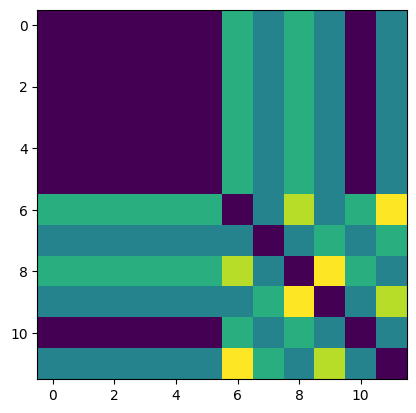

In [280]:
import numpy as np

# Generate the meshgrid
b, l = np.meshgrid(np.arange(-1, 2), np.arange(-1,1 ))

# Define the rotation matrices
c1 = np.array([[np.cos(np.deg2rad(270)), np.sin(np.deg2rad(0))],
              [-np.sin(np.deg2rad(0)), np.cos(np.deg2rad(270))]])
c2 = np.array([[np.cos(np.deg2rad(0)), -np.sin(np.deg2rad(0))],
              [np.sin(np.deg2rad(0)), np.cos(np.deg2rad(0))]])

# Reshape l and b into 2D arrays
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)

# Create xy
xy = np.concatenate([np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c1), c1.T), 
                      np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c2), c2.T)], axis=0)
plt.imshow(xy)

from scipy.spatial.distance import pdist, squareform

rdm = squareform(pdist(xy))
plt.imshow(rdm)


In [296]:
b, l = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))
b = b.flatten()
l = l.flatten()
c1 = np.array([np.cos(np.deg2rad(0)), np.sin(np.deg2rad(0))]).reshape((1, 2))
c2 = np.array([np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))]).reshape((1, 2))

l_reshaped = l.reshape((-1, 1))
b_reshaped = b.reshape((-1, 1))

xy = np.concatenate((np.dot(np.concatenate((l_reshaped, b_reshaped), axis=1), c1),
                      np.dot(np.concatenate((l_reshaped, b_reshaped), axis=1), c2)),
                     axis=0)

# if boundID == 3 or boundID == 4:
#     xy[25:, :] = xy[25:, :] @ np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))],
#                                          [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
# else:
#     xy[25:, :] = xy[25:, :] @ np.array([[np.cos(np.deg2rad(90)), -np.sin(np.deg2rad(90))],
#                                          [np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

xy = np.hstack((xy, np.vstack((np.ones_like(b), 2*np.ones_like(b))))) # add offset
rdm = squareform(pdist(xy))


ValueError: shapes (25,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)

In [268]:
xy.shape

(25, 2)

# rotate

ValueError: A 2-dimensional array must be passed.

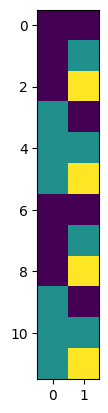

In [257]:
import numpy as np

# Generate the meshgrid
b, l = np.meshgrid(np.arange(-1, 2), np.arange(-1,1 ))

# Define the rotation matrices
c1 = np.array([[np.cos(np.deg2rad(45)), np.sin(np.deg2rad(45))],
              [-np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])
c2 = np.array([[np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45))],
              [np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])

# Reshape l and b into 2D arrays
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)
for task in [1,2,3]:
# Create xy
    xy = np.concatenate([np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c1), c1.T), 
                        np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c2), c2.T)], axis=0)
    task_xy = np.vstack(xy)
    plt.imshow(xy)

from scipy.spatial.distance import pdist, squareform

rdm = squareform(pdist(task_xy))
plt.imshow(rdm)


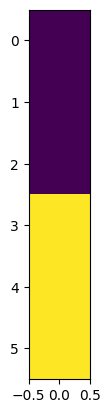

In [259]:
plt.imshow(l_2d)

# factorized - rotated

In [243]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

b, l = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))
b = b.ravel()
l = l.ravel()
c1 = np.array([np.cos(np.deg2rad(0)), np.sin(np.deg2rad(0))])
c2 = np.array([np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))])
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)
# for ii in range(len(params.num.goodSubjects)):
#     subID = params.num.goodSubjects[ii]
    # define xy coordinates
for boundID in [1,2,3]:
    xy = np.concatenate((np.dot(np.concatenate((l_2d[:, None], b_2d[:, None]), axis=1), c1) @ c1.T,
                         np.dot(np.concatenate((l_2d[:, None], b_2d[:, None]), axis=1), c2) @ c2.T))

    # rotate vectors if necessary
    if boundID == 3 or boundID == 4:
        xy[12:, :] = xy[12:, :] @ np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))],
                                             [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
    else:
        xy[12:, :] = xy[12:, :] @ np.array([[np.cos(np.deg2rad(90)), -np.sin(np.deg2rad(90))],
                                             [np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

    # add offset
    xy = np.hstack((xy, 
                    np.vstack((np.ones((len(b))), 2*np.ones((len(b))))))).T

    # compute rdm
    rdm = np.sqrt(np.sum((xy[:, None, :] - xy[None, :, :])**2, axis=-1))

plt.imshow(rdm)
    # rdm2 = helper_expandRDM(rdm, params.num.runs)
    # rdms[ii, :, :] = rdm2


ValueError: shapes (25,2,1) and (2,) not aligned: 1 (dim 2) != 2 (dim 0)

In [246]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

b, l = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))
b = b.ravel()
l = l.ravel()
c1 = np.array([np.cos(np.deg2rad(0)), np.sin(np.deg2rad(0))])
c2 = np.array([np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))])
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)

rdms = []
for boundID in [1, 2, 3]:
    xy = np.concatenate((np.dot(np.concatenate((l_2d[:, None], b_2d[:, None]), axis=1), np.reshape(c1, (2,1))) @ np.reshape(c1, (1,2)),
                         np.dot(np.concatenate((l_2d[:, None], b_2d[:, None]), axis=1), np.reshape(c2, (2,1))) @ np.reshape(c2, (1,2))))

    # rotate vectors if necessary
    if boundID == 3 or boundID == 4:
        xy[12:, :] = xy[12:, :] @ np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))],
                                             [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
    else:
        xy[12:, :] = xy[12:, :] @ np.array([[np.cos(np.deg2rad(90)), -np.sin(np.deg2rad(90))],
                                             [np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

    # add offset
    xy = np.hstack((xy, 
                    np.vstack((np.ones((len(b))), 2*np.ones((len(b))))))).T

    # compute rdm
    rdm = np.sqrt(np.sum((xy[:, None, :] - xy[None, :, :])**2, axis=-1))

    rdms.append(rdm)

plt.imshow(rdms[0])


ValueError: shapes (25,2,1) and (2,1) not aligned: 1 (dim 2) != 2 (dim 0)

In [224]:
rdm = squareform(pdist(xy))

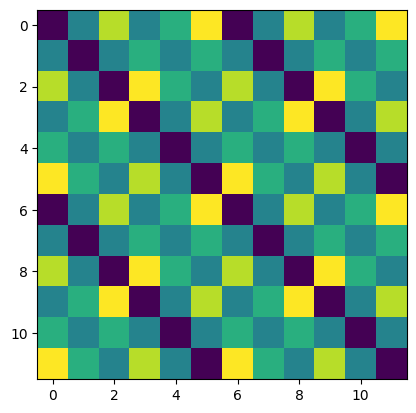

In [323]:
import numpy as np

# Generate the meshgrid
b, l = np.meshgrid(np.arange(-1, 2), np.arange(-1, 1))

# Define the rotation matrices
c1 = np.array([[np.cos(np.deg2rad(45)), np.sin(np.deg2rad(45))],
              [-np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])
c2 = np.array([[np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45))],
              [np.sin(np.deg2rad(45)), np.cos(np.deg2rad(45))]])

# Reshape l and b into 2D arrays
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)

# Create xy
xy = np.concatenate([np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c1), c1.T), 
                      np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c2), c2.T)], axis=0)

from scipy.spatial.distance import pdist, squareform

rdm = squareform(pdist(xy))
plt.imshow(rdm)

gridiness

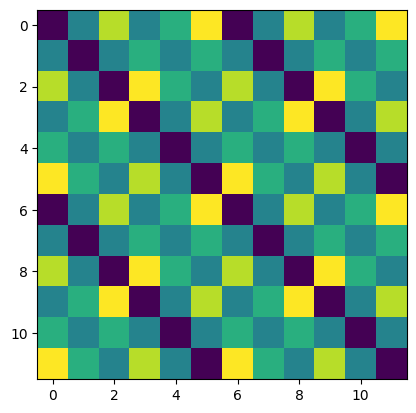

In [219]:
import numpy as np

# Generate the meshgrid
b, l = np.meshgrid(np.arange(-1, 2), np.arange(-1,1 ))

# Define the rotation matrices
c1 = np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))],
              [-np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
c2 = np.array([[np.cos(np.deg2rad(90)), -np.sin(np.deg2rad(90))],
              [-np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

# Reshape l and b into 2D arrays
l_2d = l.reshape(-1, 1)
b_2d = b.reshape(-1, 1)

# Create xy
xy = np.concatenate([np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c1), c1.T), 
                      np.dot(np.dot(np.concatenate([l_2d, b_2d], axis=1), c2), c2.T)], axis=0)
plt.imshow(xy)

from scipy.spatial.distance import pdist, squareform

rdm = squareform(pdist(xy))
plt.imshow(rdm)


In [174]:
rotation_matrix = np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))], [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
l @ rotation_matrix

In [173]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Define grid coordinates
b, l = np.meshgrid(np.arange(-2, 3), np.arange(-2, 3))
b = b.flatten()
l = l.flatten()
goodSubjects = ['sub-0061']
# Initialize array to store RDMs
rdms = np.zeros((1, 25, 25))

# for ii in range(len(goodSubjects)):
ii = 1
# subID = goodSubjects[ii]
boundID = 1 #rsData[subID]['code'][-1]

# Create grid
xy = np.vstack((np.vstack((l, b)), np.vstack((l, b))))

# Rotate grid based on boundID
if boundID == 3 or boundID == 4:
    rotation_matrix = np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))], [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
    xy[25:, :] = xy[25:, :] @ rotation_matrix
else:
    rotation_matrix = np.array([[np.cos(np.deg2rad(90)), -np.sin(np.deg2rad(90))], [np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])
    xy[25:, :] = xy[25:, :] @ rotation_matrix

# Add offset
xy = np.hstack((xy, np.vstack((np.ones((len(b), 1)), 2 * np.ones((len(b), 1))))))

# Compute RDM
rdm = squareform(pdist(xy))

# Expand RDM
rdm2 = helper_expandRDM(rdm, params.num.runs)

# Store results
rdms[ii, :, :] = rdm2

modelRDMs[1]['rdms'] = rdms
modelRDMs[1]['name'] = 'gridiness - rotated'

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 25)